In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = './data/dtd/'

images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')
print(train_dir)

./data/dtd/images\train


In [4]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [5]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [6]:
print(train_data.classes.__len__())

47


In [7]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3892
Number of validation examples: 433
Number of testing examples: 1315


In [10]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

## Defining the Model

In [11]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [13]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [14]:
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [15]:
def resnext50_32x4d_man(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

In [16]:
pretrained_model = models.resnext50_32x4d(pretrained=True)

In [17]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [19]:
pretrained_model.fc = fc

In [20]:
from torch.hub import load_state_dict_from_url

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

model = resnext50_32x4d_man()
model.fc = fc
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,076,207 trainable parameters


## Find Best LR

In [22]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

cuda


In [23]:
from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean): if this flag is set to True, `state_dict` of model and
            optimizer will be cached in memory. Otherwise, they will be saved to files
            under the `cache_dir`.
        cache_dir (string): path for storing temporary files. If no path is specified,
            system-wide temporary directory is used.
            Notice that this parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store('model', self.model.state_dict())
        self.state_cacher.store('optimizer', self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.state_cacher.retrieve('model'))
        self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")
        return self.history

    def _train_batch(self, inputs, labels):
        # Set model to training mode
        self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
            plt.xscale("log")
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.show()


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError('Given `cache_dir` is not a valid directory.')

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError('Target {} was not cached.'.format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""
        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


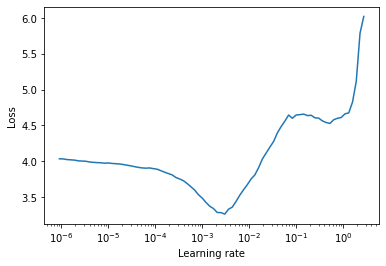

In [24]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader=train_iterator, end_lr=END_LR, num_iter=NUM_ITER)
lr_finder.plot()

In [25]:
history = lr_finder.history
print(history['lr'][history['loss'].index(min(history['loss']))])

0.0030199517204020187


In [26]:
FOUND_LR = 0.003

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [27]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [28]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [29]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [30]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 451.955 | Train Acc @1:   3.10% | Train Acc @5:  11.40%
	Valid Loss: 5445.975 | Valid Acc @1:   2.65% | Valid Acc @5:  11.95%
Epoch: 02 | Epoch Time: 1m 20s
	Train Loss: 344.419 | Train Acc @1:   3.19% | Train Acc @5:  11.83%
	Valid Loss: 4712.635 | Valid Acc @1:   1.98% | Valid Acc @5:  12.62%
Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 139.204 | Train Acc @1:   3.04% | Train Acc @5:  12.75%
	Valid Loss: 2856.075 | Valid Acc @1:   3.12% | Valid Acc @5:  14.68%


KeyboardInterrupt: 

## Examining the Model

In [31]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)
            
            print(y_pred)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [32]:
images, labels, probs = get_predictions(model, test_iterator)

tensor([[-0.1452,  0.0955, -0.2486,  ..., -0.2146,  0.2878, -0.0477],
        [-0.0929, -0.0219, -0.0528,  ..., -0.1841,  0.3479,  0.0027],
        [-0.2643,  0.3658, -0.2850,  ..., -0.0468,  0.6845, -0.1430],
        ...,
        [ 0.0650, -0.1662, -0.1752,  ..., -0.0886,  0.6422,  0.0781],
        [ 0.2230, -0.4457, -0.1810,  ..., -0.4003, -0.0368,  0.2042],
        [ 0.7431, -0.2254, -0.2568,  ...,  0.2135,  0.5914, -0.1363]],
       device='cuda:0')
tensor([[ 0.2316,  0.0222, -0.4344,  ..., -0.0830,  0.5510, -0.1083],
        [ 0.2609, -0.0013, -0.2451,  ..., -0.3954,  0.0882, -0.1694],
        [ 0.2978, -0.3752, -0.2391,  ..., -0.0811,  0.4480, -0.1449],
        ...,
        [ 0.8066, -0.4666, -0.1368,  ..., -0.1700,  0.0304, -0.3643],
        [ 0.2337,  0.0819,  0.1654,  ..., -0.5518,  0.3080, -0.0065],
        [ 0.2592, -0.0017,  0.1741,  ..., -0.4421,  0.1599,  0.0917]],
       device='cuda:0')
tensor([[ 0.6701, -0.0491,  0.1282,  ...,  0.1949,  0.1406, -0.0829],
        [ 0.97

In [33]:
pred_labels = torch.argmax(probs, 1)

In [34]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

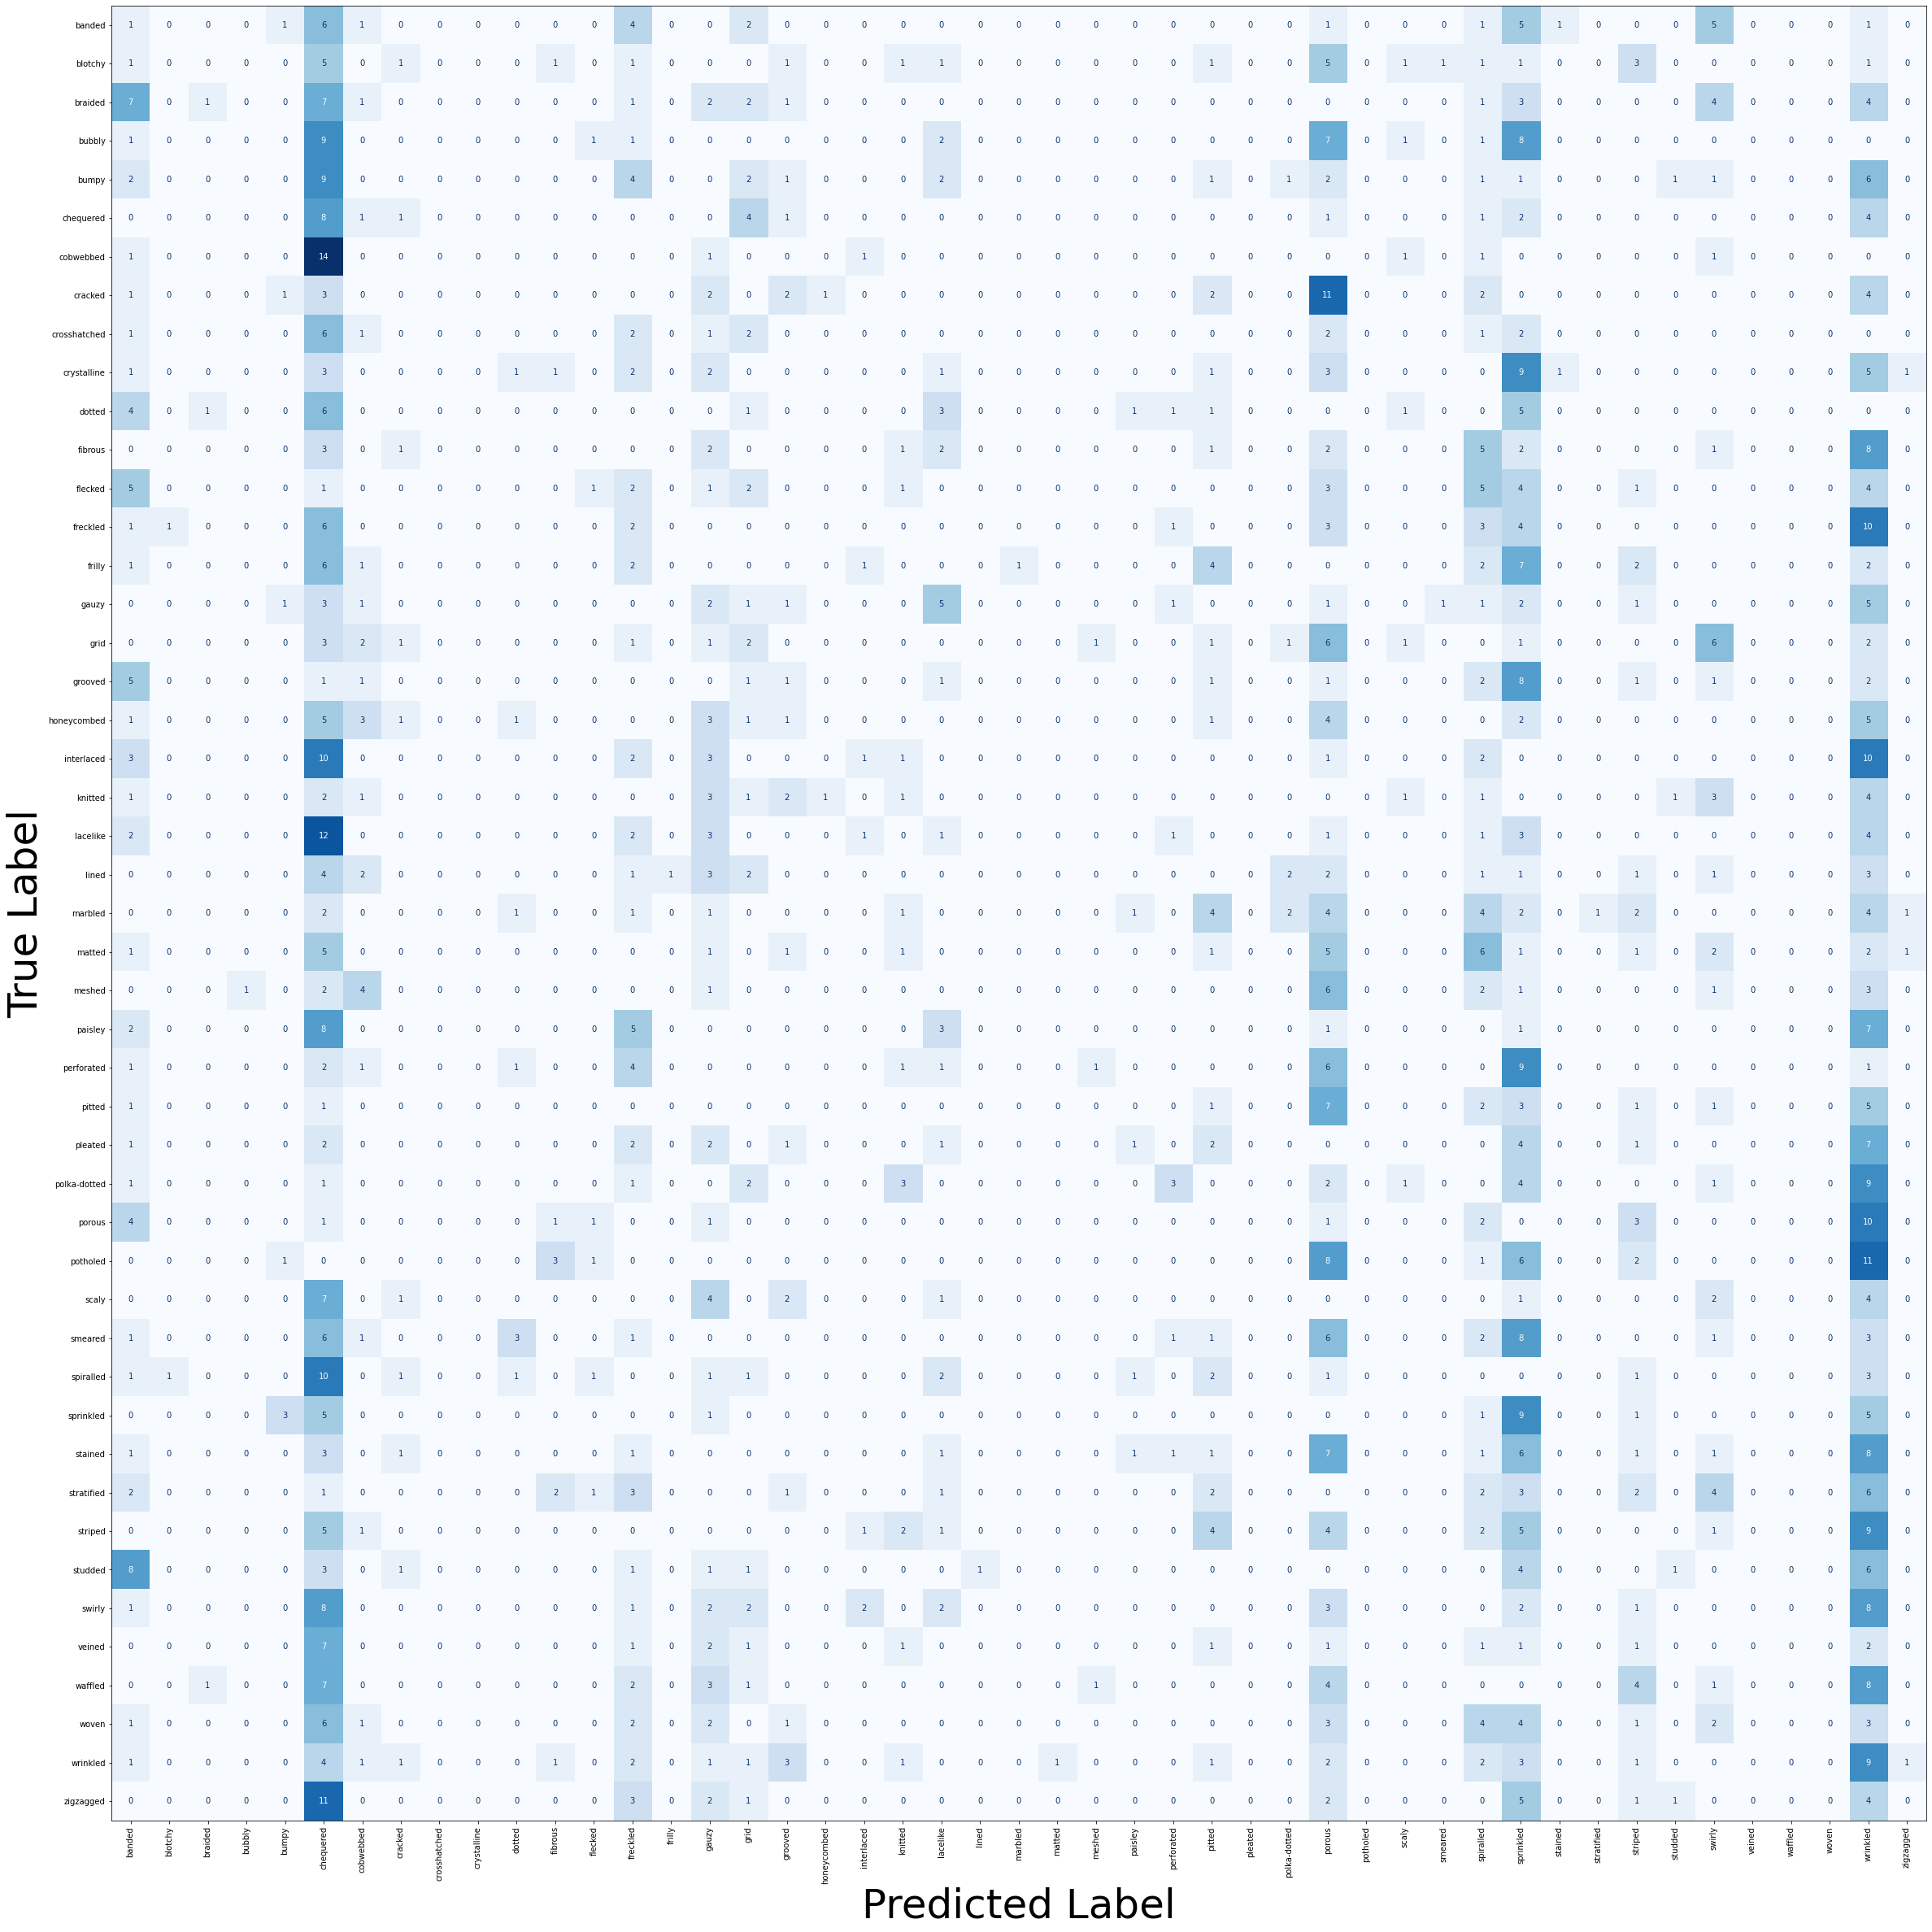

In [36]:
plot_confusion_matrix(labels, pred_labels, test_iterator.dataset.classes)

In [37]:
corrects = torch.eq(labels, pred_labels)

In [38]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [39]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

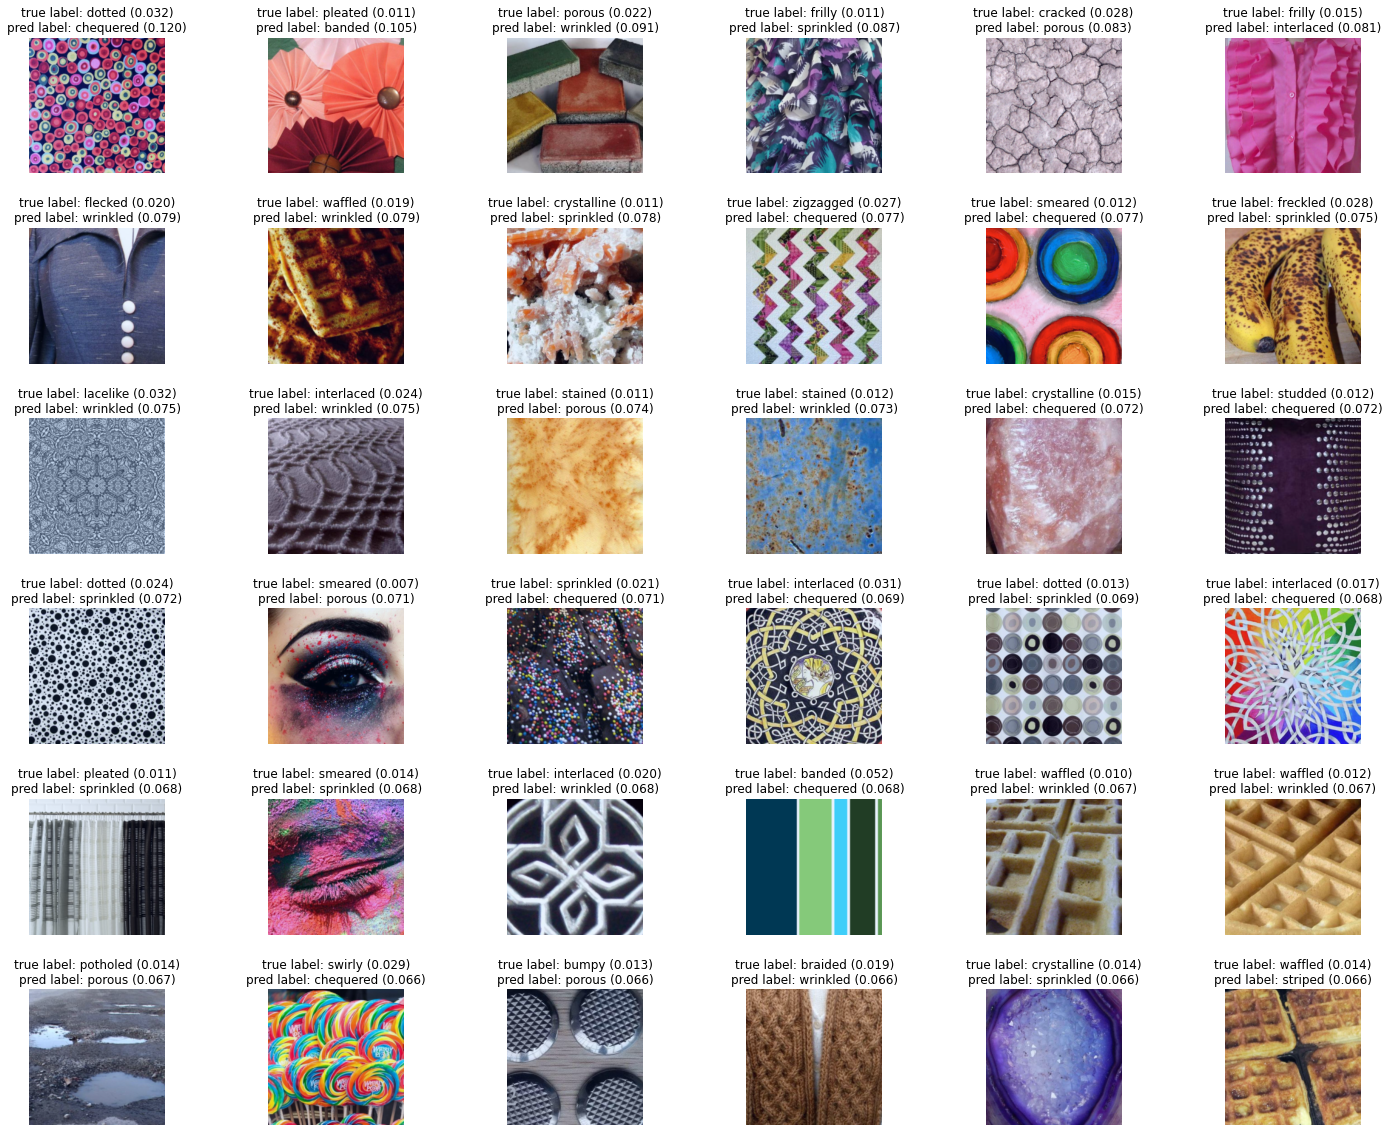

In [42]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

N_IMAGES = 36

plot_most_incorrect(incorrect_examples, test_iterator.dataset.classes, N_IMAGES)